In [11]:
import os
import torch
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import cv2
from PIL import Image
import torchvision.transforms.functional as F
import torch.nn as nn
from scipy.ndimage import filters

def xdog(files):
    size = 512
    Gamma = 0.97;
    Phi = 200;
    Epsilon = 0.1;
    k = 2.5;
    Sigma = 1.5
    im = Image.open(files).convert('L')
    im2 = filters.gaussian_filter(im, Sigma)
    im3 = filters.gaussian_filter(im, Sigma * k)
    differencedIm2 = im2 - (Gamma * im3)
    edge = 1 + np.tanh(Phi * (differencedIm2 - Epsilon))
    edge = edge.clip(0, 1)

    edge *= 255
    edge = cv2.resize(edge, (size, size), interpolation=cv2.INTER_AREA)
    return edge

def to_tensor(img, norm=False):
    img = Image.fromarray(img)
    img_t = F.to_tensor(img).float()
    if norm:
        img_t = F.normalize(img_t, mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
    return img_t

def sketch_to_tensor(sketch):
    sketch = Image.fromarray(sketch)
    sketch_t = F.to_tensor(sketch).float()
    sketch_t = F.normalize(sketch_t, mean=(0.5,), std=(0.5,))
    return sketch_t

def resize(img, height, width, center_crop=False):
    imgh, imgw = img.shape[0:2]

    if center_crop and imgh != imgw:
        # center crop
        side = np.minimum(imgh, imgw)
        j = (imgh - side) // 2
        i = (imgw - side) // 2
        img = img[j:j + side, i:i + side, ...]

    if imgh > height and imgw > width:
        inter = cv2.INTER_AREA
    else:
        inter = cv2.INTER_LINEAR
    img = cv2.resize(img, (height, width), interpolation=inter)

    return img

In [12]:
from src.transformer_models import GETransformer
from utils.utils import Config, postprocess, get_combined_mask
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

transformer_config_path = 'check_points/iLAT_ffhq_V1/transformer_config.yml'
sketch_path = 'check_points/sketch_ffhq_V1'
g_path = 'check_points/tsvqgan_ffhq_V1'

config = Config(transformer_config_path)
config.device = torch.device("cuda")
model = GETransformer(config, sketch_path, g_path, logger=None)
model.eval()
model.load(is_test=True)
model.restore_from_stage1(prefix='_best_fid')

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
Sketch Parameters:74554369
Gen Parameters:74872771
Transformer Parameters:89194240
Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Loading check_points/iLAT_ffhq_V1/iLAT_last.pth Transformer...
missing keys:[]
unexpected keys:[]
error msgs

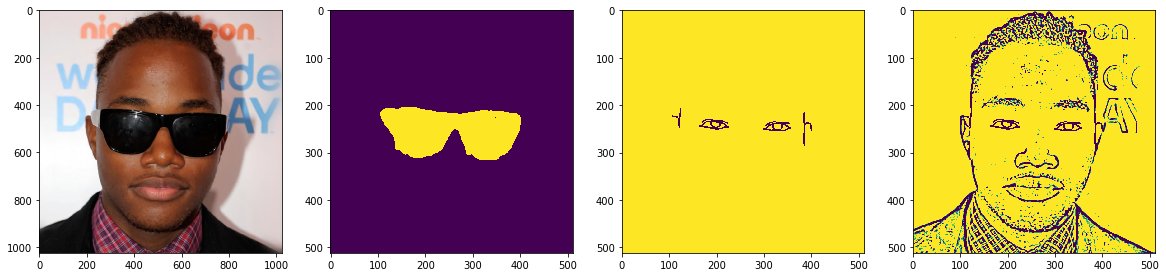

In [13]:
src_img = cv2.imread('data/samples/source/00225.png')[:,:,::-1]
mask = plt.imread('data/samples/mask/00225.png')
origin_sketch = xdog('data/samples/source/00225.png') / 255.0
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
sketch = 1. - plt.imread('data/samples/sketch/00225.png')
sketch = cv2.erode(sketch, kernel)
combined_sketch = origin_sketch * (1-mask) + sketch * mask
plt.figure(figsize=(20,5))
plt.subplot(1,4,1)
plt.imshow(src_img)
plt.subplot(1,4,2)
plt.imshow(mask)
plt.subplot(1,4,3)
plt.imshow(sketch)
plt.subplot(1,4,4)
plt.imshow(combined_sketch)
plt.show()

In [14]:
items = {}
mask = cv2.resize(mask, (256, 256), interpolation=cv2.INTER_NEAREST)
items['mask'] = to_tensor(mask).unsqueeze(0).cuda()
sketch = combined_sketch
sketch = cv2.resize(sketch, (256, 256), interpolation=cv2.INTER_AREA)
sketch = sketch_to_tensor(sketch).unsqueeze(0).cuda()
items['sketch'] = sketch
img = src_img
img = resize(img, 256, 256)
items['img'] = to_tensor(img, norm=True).unsqueeze(0).cuda()
fake_img = model.sample(items['img'],
                        items['sketch'],
                        items['mask'],
                        temperature=config.temperature,
                        greed=True, top_k=None)
m = get_combined_mask(items['mask'])
combined_img = items['img'] * (1 - m) + fake_img * m
fake_img = postprocess(fake_img)[0].cpu().numpy()
combined_img = postprocess(combined_img)[0].cpu().numpy()
print(fake_img.shape)

(256, 256, 3)


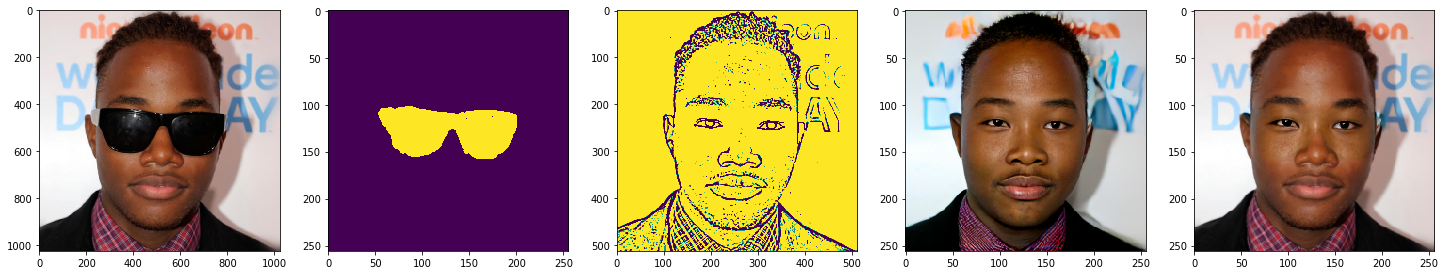

In [15]:
plt.figure(figsize=(25,5))
plt.subplot(1,5,1)
plt.imshow(src_img)
plt.subplot(1,5,2)
plt.imshow(mask)
plt.subplot(1,5,3)
plt.imshow(combined_sketch)
plt.subplot(1,5,4)
plt.imshow(fake_img)
plt.subplot(1,5,5)
plt.imshow(combined_img)
plt.show()